## Load and Preprocess data

In [ ]:
model_name = "TEdetection_distiBERT_mLM_V2"

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jun  3 11:33:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:61:00.0 Off |                    0 |
| N/A   37C    P0    55W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:62:00.0 Off |                    0 |
| N/A   

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install datasets transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import transformers
print(transformers.__version__)

2022-06-03 11:31:00.336674: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


4.19.2


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import shelve
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
results = shelve.open(os.path.join("drive", "MyDrive", "Project TE", "data", "prep_trainvalidationtest_1"),'r')
df = results["chunks"]
tok = results["tokenize_table"]
results.close

<bound method Shelf.close of <shelve.DbfilenameShelf object at 0x7f76cac54790>>

In [ ]:
np.random.seed(4711)
df = df.sample(frac=1).reset_index(drop=True) # shuffle data

In [ ]:
# get length of each chunk
l = []
for row in list(df["attention_masks"]):
  l.append(sum(row))
df["length"] = l

In [ ]:
print("number of chunks:", df.shape[0])
print("number of unique tokens in the data: ", len(tok.keys()))
print("length of each chunk in the data: ", len(df["token_ids"].iloc[0]))
print("length of shortest chunk :", df["length"].min())

number of chunks: 234563
number of unique tokens in the data:  32634
length of each chunk in the data:  150
length of shortest chunk : 1


##eliminate all chunks with only one token

without context an attention mechanism is useless

In [ ]:
df = df[df["length"] > 1]

In [ ]:
print("number of chunks:", df.shape[0])
print("number of unique tokens in the data: ", len(tok.keys()))
print("length of each chunk in the data: ", len(df["token_ids"].iloc[0]))
print("length of shortest chunk :", df["length"].min())

number of chunks: 234404
number of unique tokens in the data:  32634
length of each chunk in the data:  150
length of shortest chunk : 2


## Build masked training and validation data

In [ ]:
mask_token_id = 1 # to be checked if the model requires another pre-defined token-id

def get_masked_input_and_labels(encoded_texts):
    # 15% BERT masking
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    # Do not mask special tokens
    inp_mask[encoded_texts <= 11] = False
    # Set targets to -1 by default, it means ignore
    #labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    # Set labels for masked tokens
    #labels[inp_mask] = encoded_texts[inp_mask]

    # Prepare input
    encoded_texts_masked = np.copy(encoded_texts)
    encoded_texts_masked[inp_mask] = mask_token_id
    
    # y_labels would be same as encoded_texts i.e input tokens
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels


In [ ]:
df_training = df[df["set"] == "training"]["token_ids"]
df_validation = df[df["set"] == "validation"]["token_ids"]

In [ ]:
training_masked, training_labels = get_masked_input_and_labels(np.array([x for x in df_training.tolist()]))
validation_masked, validation_labels = get_masked_input_and_labels(np.array([x for x in df_validation.tolist()]))

In [ ]:
training_attention_mask = np.array([x for x in df[df["set"] == "training"]["attention_masks"]])
validation_attention_mask = np.array([x for x in df[df["set"] == "validation"]["attention_masks"]])

In [ ]:
training_masked[0]

array([5100, 2507, 2508, 2509, 2510, 2511, 2512,    1, 2514, 2515, 2516,
       2517, 2518, 5099, 2519, 2520, 2521, 2522, 2523, 2524,    1, 2526,
       2683, 1856, 2529, 2530,    1, 2532, 2533, 2534, 2535, 2536, 5098,
       2537, 2538, 2539,    1, 2541, 2542, 2543, 2544, 2545, 2546, 2547,
          1, 2549, 2550,    1, 2552, 2553, 2554, 2555, 5097, 5095, 2559,
       2560, 2561, 2562, 5094, 5093, 3776, 5092, 5091, 5090, 5089, 2563,
       2564, 2565, 2566, 2567,    1, 2569, 2570, 2571, 2572, 2573, 2574,
       2575, 5088, 2576, 5087, 5086,    1, 2578, 2579, 2580, 2581, 2582,
       5085, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591,    1,
          1, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2603, 5082, 5081,
          1,    1, 2607, 2608, 2609, 2610, 2611, 5080, 2614, 2643,    1,
       2645, 2646, 2647, 2648, 2649,    1, 5078, 5077, 5076,    1, 5074,
       6530, 5073, 5072, 5071, 7128,    1, 7130,    1, 2421, 5070, 5069,
          1, 5067,    1, 5065, 5064, 5063,    1], d

In [ ]:
training_labels[0]

array([5100, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516,
       2517, 2518, 5099, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526,
       2683, 1856, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 5098,
       2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547,
       2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 5097, 5095, 2559,
       2560, 2561, 2562, 5094, 5093, 3776, 5092, 5091, 5090, 5089, 2563,
       2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574,
       2575, 5088, 2576, 5087, 5086, 2577, 2578, 2579, 2580, 2581, 2582,
       5085, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592,
       2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2603, 5082, 5081,
       2605, 2606, 2607, 2608, 2609, 2610, 2611, 5080, 2614, 2643, 2644,
       2645, 2646, 2647, 2648, 2649, 5079, 5078, 5077, 5076, 5075, 5074,
       6530, 5073, 5072, 5071, 7128, 7129, 7130, 7131, 2421, 5070, 5069,
       5068, 5067, 5066, 5065, 5064, 5063, 5062], d

In [ ]:
training_attention_mask[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
validation_masked[0]

array([ 4691,  4690,   250,  8018, 15176, 13015,     1,  4689,  4687,
        4686,  4685,     1,  4681,     1,  4679,  4678,  4677,  4676,
        4675,  4674,  4673,  4672,     1,  4670,  4669,  4668,  4667,
        4666,  4665,  4664,  4663,  4662,  4661,     1,  4659,  4658,
        4657,  4656,  4655,  4654,  4653,  4652,  6648,  6649, 12748,
        6651, 13529,     1,  5018, 15991, 15992, 15993,     1, 15994,
           1, 15995,  6592, 15374,  9269, 15375, 11109,  9739,     1,
       13524,     1,  6603,  6663,  6664,  6668,  6669,  4651, 13522,
        4650,  4649,     1,  4647,  4646,  4645,  4644,  4643,  4642,
           1,  4640,  4639,  4638,  4637,  4636,  4635,  4634,  4633,
           1,  4631,  4630,     1,     1,  4627,  4626,  4625,  4624,
        4623,  4622,  4621,  4620,  4619,  4591,  4590,  4589,  4588,
           1,     1,  4585,  4584,  4583,  4582,  4581,  4580,  4579,
        4578,  4577,  4576,     1,  4574,  4573,  4572,  4571,  4570,
        4569,  4568,

In [ ]:
validation_labels

array([[4691, 4690,  250, ..., 4548, 4547, 4546],
       [4162, 4163, 4164, ..., 4306, 4307, 4308],
       [1561, 1560, 1559, ..., 1337, 1336, 1335],
       ...,
       [3696, 3697, 6883, ..., 4024, 4025, 4026],
       [4486, 4490, 4491, ..., 4643, 4645, 4646],
       [2327, 2328, 2329, ..., 2504, 2505, 2506]], dtype=int32)

### Convert the data dictionaries


    there are three possibilities you can use to gather all the input Tensors in the first positional argument :

    a single Tensor with input_ids only and nothing else: model(inputs_ids)
    a list of varying length with one or several input Tensors IN THE ORDER given in the docstring: model([input_ids, attention_mask])
    a dictionary with one or several input Tensors associated to the input names given in the docstring: model({"input_ids": input_ids})


In [ ]:
# data has been reduced to first 100 rows for training and 20 rows for validation.
# This should be changed to the full data as soon as we see the model.fit running without bugs

tf_train_dict = { 'input_ids': tf.convert_to_tensor(training_masked), #[0:100]),
           'attention_mask': tf.convert_to_tensor(training_attention_mask), #[0:100]),
           'labels': tf.convert_to_tensor(training_labels) #[0:100])
         }

In [ ]:
tf_val_dict = { 'input_ids': tf.convert_to_tensor(validation_masked), #[0:20]),
           'attention_mask': tf.convert_to_tensor(validation_attention_mask), #[0:20]),
           'labels': tf.convert_to_tensor(validation_labels), #[0:20])
         }

## Functions for saving models and weights

    # Restore the weights
    model.load_weights(path)

    # Evaluate the model
    loss, acc = model.evaluate(test_images, test_labels, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
def save_my_model_weights():
    d = str(datetime.now())
    checkpoint_name = model_name + "-" + d[0:10] + "-" + d[11:13] + "-" + d[14:16]
    checkpoint_dir = os.path.join("drive", "MyDrive", "Project TE", "models", checkpoint_name)
    model.save_weights(checkpoint_dir)
    return

## Initialize the model
    freshly initialize a DistilBERT model. We’ll use the same configuration for our model as for the distilbert-base-uncased model, so we load the pretrained configuration, make sure that the tokenizer size matches the model vocabulary size and max length of embeddings matches length of our chunks. 


In [ ]:
from transformers import TFDistilBertForMaskedLM, AutoConfig

config = AutoConfig.from_pretrained(
    "distilbert-base-uncased",
    vocab_size=len(tok.keys())+11,   # +11 for the reserved special tokens
    max_position_embeddings=len(df["token_ids"].iloc[0])
)

## Load a new (not pretrained) model
Load a new model. Note that we don’t use the from_pretrained() function, since we’re actually initializing a model ourself:

In [ ]:
model = TFDistilBertForMaskedLM(config)
model(model.dummy_inputs)  # Builds the model
model.summary()

Model: "tf_distil_bert_for_masked_lm_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 67715328  
 nLayer)                                                         
                                                                 
 vocab_transform (Dense)     multiple                  590592    
                                                                 
 vocab_layer_norm (LayerNorm  multiple                 1536      
 alization)                                                      
                                                                 
 vocab_projector (TFDistilBe  multiple                 25220741  
 rtLMHead)                                                       
                                                                 
Total params: 68,340,101
Trainable params: 68,340,101
Non-trainable params: 0
________________________

## Compile the model
configure the training hyperparameters and call compile() and fit(). We’ll use a learning rate schedule with some warmup to improve the stability of training:

In [ ]:
# with tensorflow

from transformers import create_optimizer
import tensorflow as tf

num_train_steps = len(training_masked) #[0:100])   ## change this when training with the full data
optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=1_000,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour, please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


## Train the model

In [ ]:
loss = []
val_loss = []

In [ ]:
t_p = {   # training parameters
        "nb_all_train_rows": len(training_masked), # rows in training data

        "mini_batch_size": 32, # rows per mini_batch (tensorflow parameter)
        "batch_size": 512, # mini_batches per batch (inner loop)
        "step_size": 1, # batches per step (print progress)
        "epochs": 10, # how many times full data will be processed (outer loop)

        "start_row": 0, # for full data training: start_row = 0
                          # for partial data training: early_stop = x (only from x. rows in data will be used for training)
        "early_stop": 200, # for full data training: early_stop = nb_all_train_rows
                           # for partial data training: early_stop = x (only x rows in data will be used for training)
}
t_p["early_stop"] = t_p["nb_all_train_rows"]
t_p

{'batch_size': 512,
 'early_stop': 209018,
 'epochs': 10,
 'mini_batch_size': 32,
 'nb_all_train_rows': 209018,
 'start_row': 0,
 'step_size': 1}

In [ ]:
#from transformers.keras_callbacks import PushToHubCallback
#callback = PushToHubCallback(output_dir="codeparrot-ds", tokenizer=tokenizer)

steps = (t_p["early_stop"] - t_p["start_row"]) / t_p["mini_batch_size"] / t_p["batch_size"] / t_p["step_size"]
if steps % 1 > 0:
    steps = steps + 1
steps = int(steps)

for epoch in range(0,t_p["epochs"]):
    step = 0
    for start in range(t_p["start_row"], min(t_p["early_stop"]+t_p["start_row"], t_p["nb_all_train_rows"]) , t_p["mini_batch_size"] * t_p["batch_size"]):
        if step % t_p["step_size"] == 0:
            print("epoch", epoch+1, "/", t_p["epochs"], ", step", (step // t_p["step_size"]) + 1, "/", steps)
        step = step + 1    
        end = min(start + t_p["mini_batch_size"] * t_p["batch_size"], min(t_p["early_stop"]+t_p["start_row"], t_p["nb_all_train_rows"])) 
        print ("start/end/length", start, "/", end, "/", end-start)
        mini_batch = { 'input_ids': tf.convert_to_tensor(training_masked[start: end]),
                      'attention_mask': tf.convert_to_tensor(training_attention_mask[start: end]),
                      'labels': tf.convert_to_tensor(training_labels[start: end])
         }

        history = model.fit(mini_batch, validation_data=tf_val_dict, epochs=1, batch_size = t_p["mini_batch_size"], verbose=1) #, callbacks=[callback])
        loss.extend(list(history.history['loss']))
        val_loss.extend(list(history.history['val_loss']))

    save_my_model_weights() # save after each epoch

print("--------------------------- end ---------------------------------")

epoch 1 / 10 , step 1 / 13
start/end/length 0 / 16384 / 16384
512/512 [==============================] - 293s 556ms/step - loss: 6.9761 - val_loss: 2.1796
epoch 1 / 10 , step 2 / 13
start/end/length 16384 / 32768 / 16384
512/512 [==============================] - 283s 553ms/step - loss: 1.8086 - val_loss: 1.3930
epoch 1 / 10 , step 3 / 13
start/end/length 32768 / 49152 / 16384
512/512 [==============================] - 283s 553ms/step - loss: 1.4177 - val_loss: 1.3575
epoch 1 / 10 , step 4 / 13
start/end/length 49152 / 65536 / 16384
512/512 [==============================] - 283s 553ms/step - loss: 1.3706 - val_loss: 1.2835
epoch 1 / 10 , step 5 / 13
start/end/length 65536 / 81920 / 16384
512/512 [==============================] - 283s 552ms/step - loss: 1.1685 - val_loss: 1.0409
epoch 1 / 10 , step 6 / 13
start/end/length 81920 / 98304 / 16384
512/512 [==============================] - 283s 552ms/step - loss: 1.0080 - val_loss: 0.9608
epoch 1 / 10 , step 7 / 13
start/end/length 98304 

####Plot training and validation loss per step

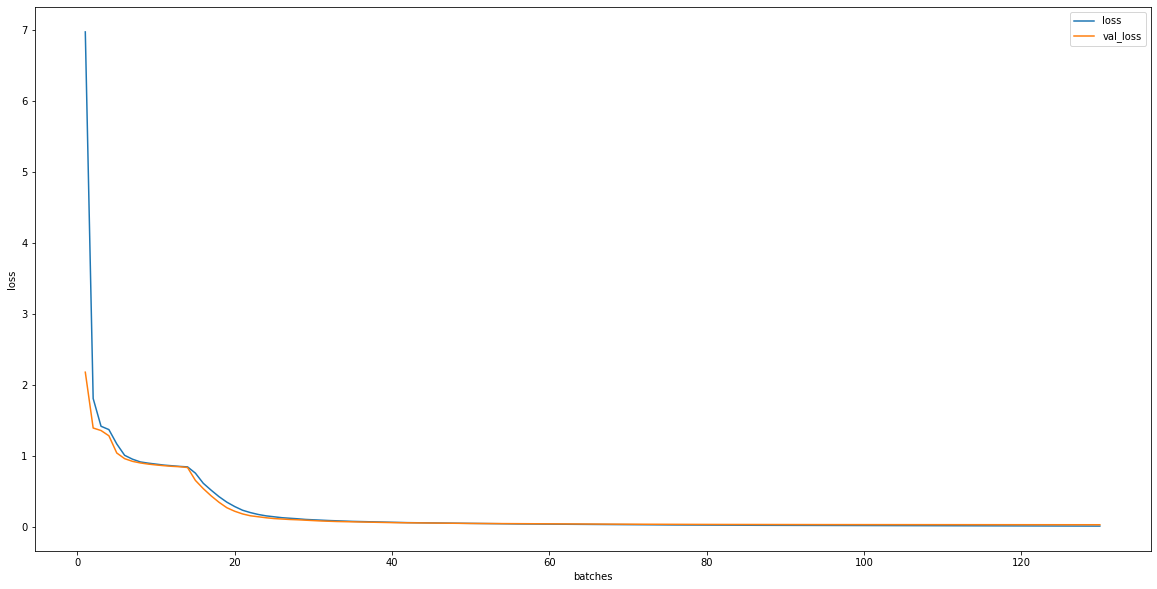

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(range(1, len(loss)+1),loss)
plt.plot(range(1, len(val_loss)+1),val_loss)
plt.ylabel('loss')
plt.xlabel('batches')
plt.legend(['loss', 'val_loss'])
plt.show()

## Get an output from a pretrained model

In [ ]:
def get_prediction(i, predictions):
    probs = tf.nn.softmax(predictions[0, i])
    result = tf.math.top_k(probs, k=3)
    pred = [result.indices.numpy(), result.values.numpy()]

    return pred

####Restore model
  run this only if necessary

In [ ]:
# Restore the model
break # intensional break

checkpoint_name = "TE_basic_V3-2022-06-01-15-34" # copy paste checkpoint name 
checkpoint_dir = os.path.join("drive", "MyDrive", "Project TE", "models", ".", checkpoint_name)
model.load_weights(checkpoint_dir)

SyntaxError: ignored

#### Define input: Select a single chunk input from data

In [ ]:
test_element = 101
input = validation_masked[test_element]
target = validation_labels[test_element]

#### Predict with the pretrained model

In [ ]:
outputs = model(input)

#### Evaluate the result

In [ ]:
input

array([  583,   582,   581,   580,   579,     1,   577,   576,     1,
         574,   573,   572,   571,   570,   569,   568,   567,   566,
       10102, 17140, 10103,     1,   562,     1,  5588,   560,   559,
         558,   557,   556,   555,   554,   553,   552,   551,   550,
           1,   548,   547,   546,  5590,   545,     1,   543,   542,
         541,   540,   539,     1,   537,     1,   535,   534,   533,
           1,   531,   530,   528,   527,     1,   525,     1,   522,
         521,   520,     1,   518,     1,   516,   515,   514,   513,
         512,   511,   510,   509,   508,   507,   506,   505,     1,
           1,   502,   501,   500,   499,   498,   497,     1,   495,
         480,   479,   478,   477,   476,   475,   474,   473,   472,
         471,   470,   469,   468,   467,     1,   465,   464,   463,
         462,   461,   460,     1,   458,     1,   456,   455,   454,
       10439, 10438, 10030, 10437, 10436, 10435,   453,   452,   451,
         379,   378,

In [ ]:
target

array([  583,   582,   581,   580,   579,   578,   577,   576,   575,
         574,   573,   572,   571,   570,   569,   568,   567,   566,
       10102, 17140, 10103,   564,   562,   561,  5588,   560,   559,
         558,   557,   556,   555,   554,   553,   552,   551,   550,
         549,   548,   547,   546,  5590,   545,   544,   543,   542,
         541,   540,   539,   538,   537,   536,   535,   534,   533,
         532,   531,   530,   528,   527,   526,   525,   524,   522,
         521,   520,   519,   518,   517,   516,   515,   514,   513,
         512,   511,   510,   509,   508,   507,   506,   505,   504,
         503,   502,   501,   500,   499,   498,   497,   496,   495,
         480,   479,   478,   477,   476,   475,   474,   473,   472,
         471,   470,   469,   468,   467,   466,   465,   464,   463,
         462,   461,   460,   459,   458,   457,   456,   455,   454,
       10439, 10438, 10030, 10437, 10436, 10435,   453,   452,   451,
         379,   378,

In [ ]:
i = 0
for x in input:
    if x == 1:
        print("at position: ", i, 
              "\n\tprediction is:", get_prediction(i, outputs[0])[0],
              "\n\tweight is:", get_prediction(i, outputs[0])[1],
              "\n\ttarget was: ", target[i])
    i = i+1
            

at position:  5 
	prediction is: [ 578 7462  580] 
	weight is: [9.9997699e-01 1.3225922e-05 2.3608502e-06] 
	target was:  578
at position:  8 
	prediction is: [ 575  572 6754] 
	weight is: [9.9984205e-01 2.4215751e-05 1.8149080e-05] 
	target was:  575
at position:  21 
	prediction is: [  564   565 10102] 
	weight is: [0.9384317  0.03020885 0.01044601] 
	target was:  564
at position:  23 
	prediction is: [ 561 1249  563] 
	weight is: [0.99263424 0.00458285 0.00133898] 
	target was:  561
at position:  36 
	prediction is: [549 546 544] 
	weight is: [9.9992681e-01 5.7362617e-05 8.8635232e-07] 
	target was:  549
at position:  42 
	prediction is: [ 544 5595 1207] 
	weight is: [9.9993753e-01 2.9643656e-05 5.2396913e-06] 
	target was:  544
at position:  48 
	prediction is: [538 535 409] 
	weight is: [9.9999917e-01 1.6845767e-07 1.6421546e-07] 
	target was:  538
at position:  50 
	prediction is: [536 533 538] 
	weight is: [9.9999726e-01 8.5119842e-07 3.4050032e-07] 
	target was:  536
at positio

## Log in to huggingface

from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


#### Push the model to hub

In [ ]:
from transformers import AutoModel

# Push the model to your namespace with the name model_name and have a local clone in the
# *model_name* folder.
model.push_to_hub(model_name, use_auth_token="...")

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='TEdetection_distiBERT_mLM_V2' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:676: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/FritzOS/TEdetection_distiBERT_mLM_V2 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/357M [00:00<?, ?B/s]

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/FritzOS/TEdetection_distiBERT_mLM_V2
   e95f822..aaebda3  main -> main



'https://huggingface.co/FritzOS/TEdetection_distiBERT_mLM_V2/commit/aaebda3b3f120ffd62ed8dbd3d9fd815c224e2b5'